# Imports

In [1]:
# Basics
import numpy as np
import pandas as pd
import os
from scipy import stats
from scipy import math
from math import sqrt 
import requests
import datetime
from datetime import datetime

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics and Models
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.api import Holt

# Custom
import wrangle
import prepare


# plotting defaults
plt.rc('figure', figsize=(11, 5))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

In [2]:
# Borrowed from Codeup
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [3]:
# Borrowed from Codeup
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [49]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

# Exercises
   - Split data (train/validate/test) and resample by any period except daily. Aggregate using the sum.
   - Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
      -  Simple Average
      -  Moving Average
      -  Holt's Linear Trend Model
      -  Based on previous year/month/etc., this is up to you.


In [4]:
df = wrangle.store_item_sales()
df = prepare.prep_store_data(df)
df.head(3)

Reading merged data from csv file...


,quantity,sale_id,store_id,item_brand,item_name,item_price,item_upc12,item_upc14,store_address,store_city,store_state,store_zipcode,sales_total,month,day_of_week
sale_date,,,,,,,,,,,,,,,
2013-01-01,13.0,1,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,10.92,January,Tuesday
2013-01-01,26.0,211817,7,Mueller,Mueller Sport Care Basic Support Level Medium Elastic Knee Support,8.40,74676640211,74676640211,12018 Perrin Beitel Rd,San Antonio,TX,78217,218.40,January,Tuesday
2013-01-01,27.0,832657,7,Mama Marys,Pizza Sauce,4.65,35457770664,35457770664,12018 Perrin Beitel Rd,San Antonio,TX,78217,125.55,January,Tuesday


In [5]:
df.shape

(913000, 15)

In [6]:
# Resample data to a day-to-day representation by agg same days together
df = df.resample('d')[['sales_total', 'quantity']].sum()

# remove leap day for the sake of congruent seasonal analysis
df= df[df.index != '2016-02-29']

In [7]:
df.shape

(1825, 2)

In [8]:
df.head()

,sales_total,quantity
sale_date,,
2013-01-01,73844.01,13696.0
2013-01-02,73570.58,13678.0
2013-01-03,78169.48,14488.0
2013-01-04,84467.73,15677.0
2013-01-05,87621.85,16237.0


In [9]:
# Since I know there is repeated seasonality, I can split the data by year

train = df.loc[:'2015']
validate = df.loc['2016']
test = df.loc['2017']

train.shape, validate.shape, test.shape

((1095, 2), (365, 2), (365, 2))

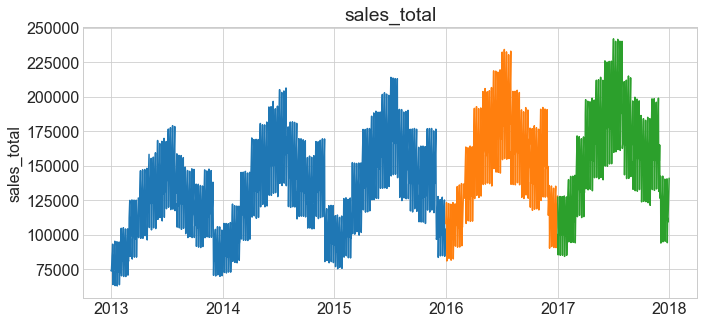

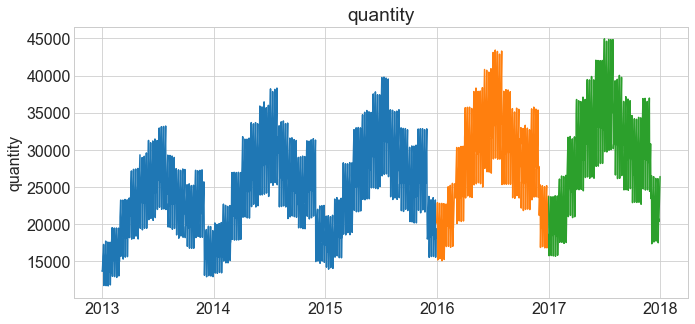

In [10]:
# plot to visualize train, validate, test split

for col in train.columns:
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

## Now that I have my split, build an empty dataframe to store my models and their perfomance metrics
------
### Potential Models to Fit
- Last Observed Value
- Simple Average
- Moving Average
    - Seperate Potential Timeframes
- Holt's Linear Trend
- Previous Cycle
- FB Prophet Model

In [11]:
# Empty Metric DataFrame
metrics_df = pd.DataFrame(columns=['model', 'target_var', 'RMSE'])
metrics_df

,model,target_var,RMSE


In [12]:
# Function to append metrics to dataframe
def append_metrics_df(model, target_var):
    '''
    
    '''
    rmse = evaluate(target_var)
    dic = {'model': [model], 'target_var': [target_var],
        'RMSE': [rmse]}
    dic = pd.DataFrame(dic)
    return metrics_df.append(dic, ignore_index = True)

In [13]:
print(train['sales_total'][-1:][0])
print(train['quantity'][-1:][0])

train.tail(1)

103969.42
19377.0


,sales_total,quantity
sale_date,,
2015-12-31,103969.42,19377.0


In [14]:
# Last Observed Values

sales = 103969.42
quantity = 19377.0

yhat_df = pd.DataFrame({'sales_total':[sales], 'quantity':[quantity]}, index=validate.index)

yhat_df.head()

,sales_total,quantity
sale_date,,
2016-01-01,103969.42,19377.0
2016-01-02,103969.42,19377.0
2016-01-03,103969.42,19377.0
2016-01-04,103969.42,19377.0
2016-01-05,103969.42,19377.0


sales_total -- RMSE: 58901


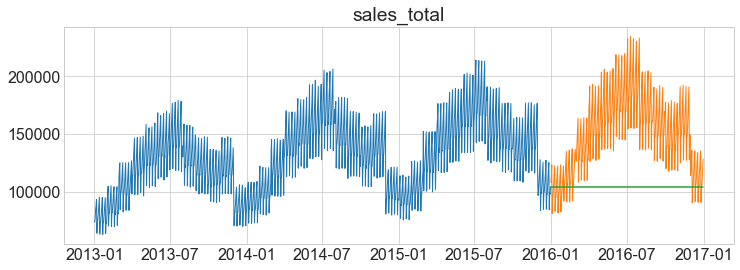

quantity -- RMSE: 10927


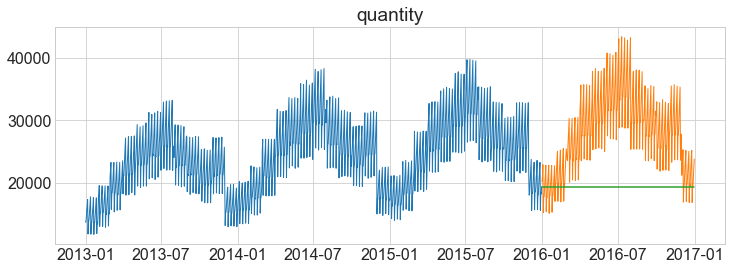

In [15]:
# Visualize
for col in train.columns:
    plot_and_eval(col)

In [16]:
# Evaluate using RMSE and and Metrics to the metric_df

for col in train.columns:
    metrics_df = append_metrics_df(model = 'last_observed_value', 
                             target_var = col)

In [17]:
# Verify that my metrics made it to the dataframe
metrics_df

,model,target_var,RMSE
0,last_observed_value,sales_total,58901.0
1,last_observed_value,quantity,10927.0


In [18]:

# Simple Average
sales = round(train['sales_total'].mean(), 2)
quantity = round(train['quantity'].mean(), 2)

quantity, sales

(24304.67, 130674.85)

In [19]:
yhat_df = pd.DataFrame({'sales_total':[sales], 'quantity':[quantity]}, index=validate.index)

yhat_df.head()

,sales_total,quantity
sale_date,,
2016-01-01,130674.85,24304.67
2016-01-02,130674.85,24304.67
2016-01-03,130674.85,24304.67
2016-01-04,130674.85,24304.67
2016-01-05,130674.85,24304.67


sales_total -- RMSE: 40025


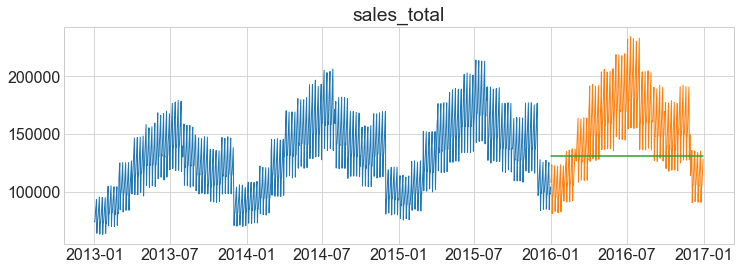

quantity -- RMSE: 7447


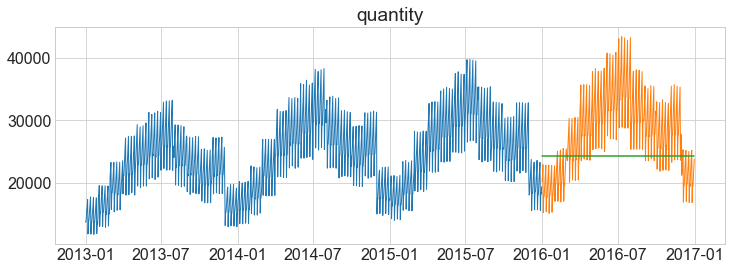

In [20]:
# Visualize
for col in train.columns:
    plot_and_eval(col)

In [21]:
# Evaluate using RMSE and and Metrics to the metric_df

for col in train.columns:
    metrics_df = append_metrics_df(model = 'simple_average', 
                             target_var = col)

In [22]:
metrics_df

,model,target_var,RMSE
0,last_observed_value,sales_total,58901.0
1,last_observed_value,quantity,10927.0
2,simple_average,sales_total,40025.0
3,simple_average,quantity,7447.0


In [23]:
# Moving/Rolling Average
# 7 days

period = 7

sales = round(train['sales_total'].rolling(period).mean()[-1], 2)
quantity = round(train['quantity'].rolling(period).mean()[-1], 2)

quantity, sales

(19705.86, 105982.68)

In [24]:
yhat_df = pd.DataFrame({'sales_total':[sales], 'quantity':[quantity]}, index=validate.index)

yhat_df.head()

,sales_total,quantity
sale_date,,
2016-01-01,105982.68,19705.86
2016-01-02,105982.68,19705.86
2016-01-03,105982.68,19705.86
2016-01-04,105982.68,19705.86
2016-01-05,105982.68,19705.86


sales_total -- RMSE: 57261


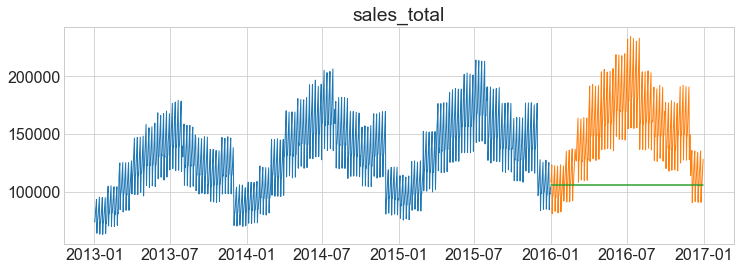

quantity -- RMSE: 10659


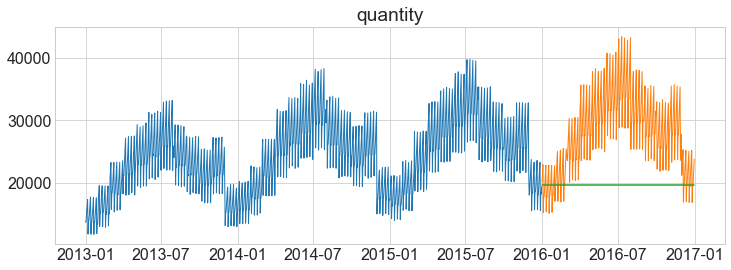

In [25]:
# Visualize
for col in train.columns:
    plot_and_eval(col)

In [26]:
# Evaluate using RMSE and and Metrics to the metric_df

for col in train.columns:
    metrics_df = append_metrics_df(model = 'moving_average_7', 
                             target_var = col)

In [27]:
metrics_df

,model,target_var,RMSE
0,last_observed_value,sales_total,58901.0
1,last_observed_value,quantity,10927.0
2,simple_average,sales_total,40025.0
3,simple_average,quantity,7447.0
4,moving_average_7,sales_total,57261.0
5,moving_average_7,quantity,10659.0


In [28]:
# Moving/Rolling Average
# 30 days

period = 30

sales = round(train['sales_total'].rolling(period).mean()[-1], 2)
quantity = round(train['quantity'].rolling(period).mean()[-1], 2)

quantity, sales

(19651.87, 105739.12)

In [29]:
yhat_df = pd.DataFrame({'sales_total':[sales], 'quantity':[quantity]}, index=validate.index)

yhat_df.head()

,sales_total,quantity
sale_date,,
2016-01-01,105739.12,19651.87
2016-01-02,105739.12,19651.87
2016-01-03,105739.12,19651.87
2016-01-04,105739.12,19651.87
2016-01-05,105739.12,19651.87


sales_total -- RMSE: 57458


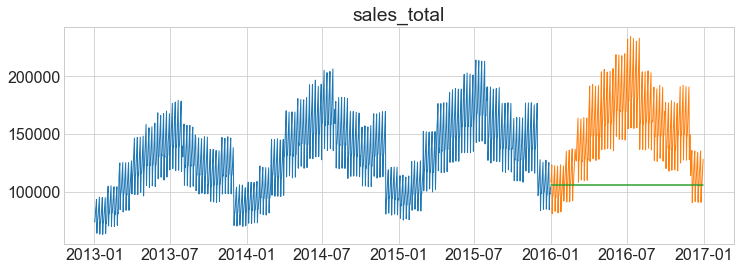

quantity -- RMSE: 10703


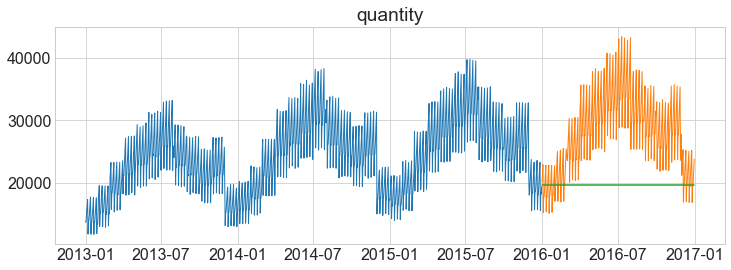

In [30]:
# Visualize
for col in train.columns:
    plot_and_eval(col)

In [31]:
# Evaluate using RMSE and and Metrics to the metric_df

for col in train.columns:
    metrics_df = append_metrics_df(model = 'moving_average_30', 
                             target_var = col)
    
metrics_df

,model,target_var,RMSE
0,last_observed_value,sales_total,58901.0
1,last_observed_value,quantity,10927.0
2,simple_average,sales_total,40025.0
3,simple_average,quantity,7447.0
4,moving_average_7,sales_total,57261.0
5,moving_average_7,quantity,10659.0
6,moving_average_30,sales_total,57458.0
7,moving_average_30,quantity,10703.0


sales_total 

quantity 



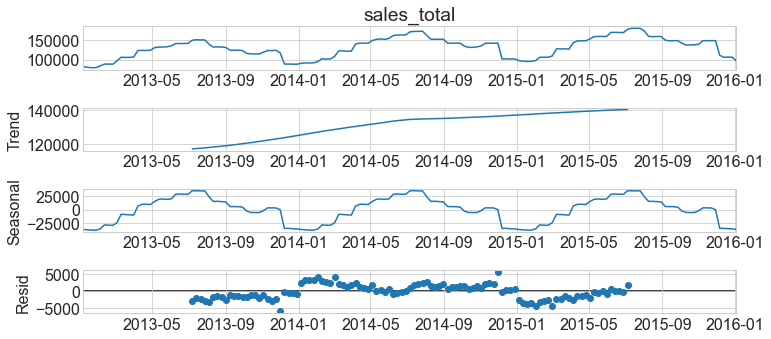

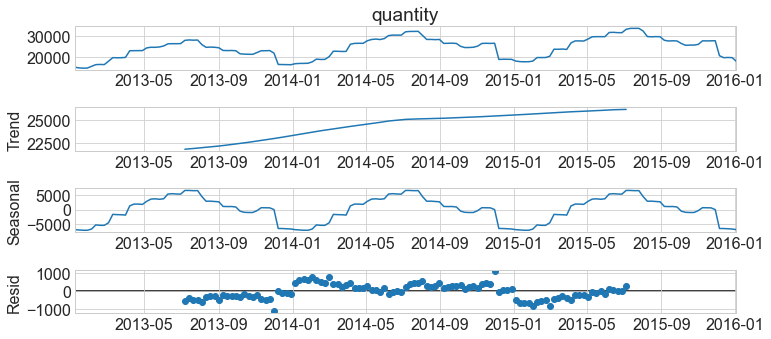

In [32]:
# Holt's Linear Trend
for col in train.columns:
    print(col,'\n')
    sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()

In [35]:
col = 'sales_total'

# Build the Model
model = Holt(train[col], exponential=False, damped=True)

# Fit the Model
model = model.fit(optimized=True)

/var/folders/08/8cpsy8b90ddg4tfjy9502gzw0000gn/T/ipykernel_5731/2140946997.py:4: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  model = Holt(train[col], exponential=False, damped=True)
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [36]:
# Predict with Model
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_quantity = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_quantity, 2)
    
yhat_df

/var/folders/08/8cpsy8b90ddg4tfjy9502gzw0000gn/T/ipykernel_5731/638045356.py:3: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  model = Holt(train[col], exponential=False, damped=True)
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was prov

,sales_total,quantity
sale_date,,
2016-01-01,98907.82,18384.41
2016-01-02,98226.41,18257.47
2016-01-03,97551.81,18131.79
2016-01-04,96883.96,18007.38
2016-01-05,96222.79,17884.20
...,...,...
2016-12-27,32576.86,6027.30
2016-12-28,32558.76,6023.93
2016-12-29,32540.84,6020.59


sales_total -- RMSE: 112716


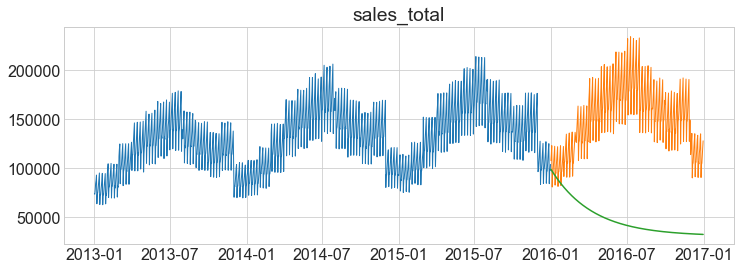

quantity -- RMSE: 20996


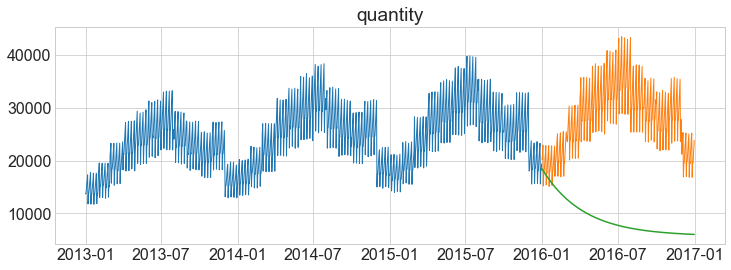

In [37]:
# Visualize
for col in train.columns:
    plot_and_eval(col)

In [38]:
# Evaluate using RMSE and and Metrics to the metric_df

for col in train.columns:
    metrics_df = append_metrics_df(model = 'holt_linear', 
                             target_var = col)
    
metrics_df

,model,target_var,RMSE
0,last_observed_value,sales_total,58901.0
1,last_observed_value,quantity,10927.0
2,simple_average,sales_total,40025.0
3,simple_average,quantity,7447.0
4,moving_average_7,sales_total,57261.0
5,moving_average_7,quantity,10659.0
6,moving_average_30,sales_total,57458.0
7,moving_average_30,quantity,10703.0
8,holt_linear,sales_total,112716.0
9,holt_linear,quantity,20996.0


In [39]:
# Previous Cycle
# 1 year cycle

yhat_df = train['2015'] + train.diff(365).mean()

yhat_df.head()

/var/folders/08/8cpsy8b90ddg4tfjy9502gzw0000gn/T/ipykernel_5731/413500209.py:4: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  yhat_df = train['2015'] + train.diff(365).mean()


,sales_total,quantity
sale_date,,
2015-01-01,104337.620493,19411.813699
2015-01-02,112870.770493,20904.813699
2015-01-03,118245.300493,21983.813699
2015-01-04,125496.760493,23286.813699
2015-01-05,88551.940493,16420.813699


In [40]:
# set yhat_df to validate index
yhat_df.index = validate.index

yhat_df.head()

,sales_total,quantity
sale_date,,
2016-01-01,104337.620493,19411.813699
2016-01-02,112870.770493,20904.813699
2016-01-03,118245.300493,21983.813699
2016-01-04,125496.760493,23286.813699
2016-01-05,88551.940493,16420.813699


sales_total -- RMSE: 28087


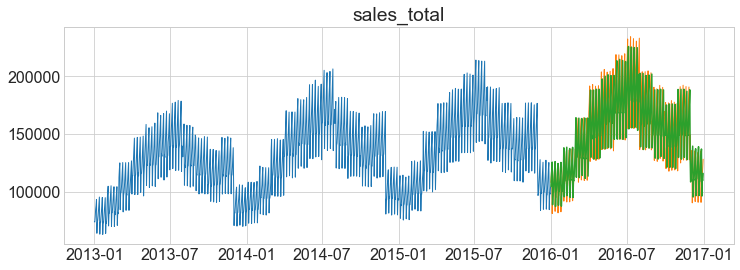

quantity -- RMSE: 5223


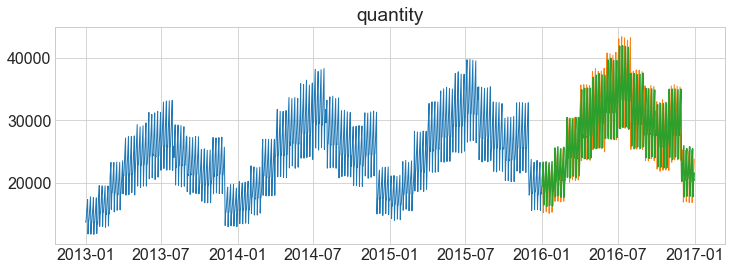

In [41]:
# Visualize
for col in train.columns:
    plot_and_eval(col)

In [42]:
# Evaluate using RMSE and and Metrics to the metric_df

for col in train.columns:
    metrics_df = append_metrics_df(model = 'previous_year', 
                             target_var = col)
    
metrics_df

,model,target_var,RMSE
0,last_observed_value,sales_total,58901.0
1,last_observed_value,quantity,10927.0
2,simple_average,sales_total,40025.0
3,simple_average,quantity,7447.0
4,moving_average_7,sales_total,57261.0
5,moving_average_7,quantity,10659.0
6,moving_average_30,sales_total,57458.0
7,moving_average_30,quantity,10703.0
8,holt_linear,sales_total,112716.0
9,holt_linear,quantity,20996.0


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


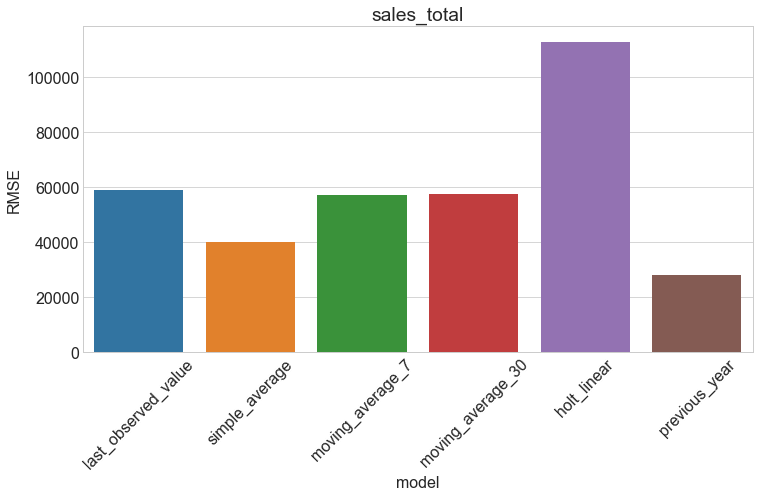

/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


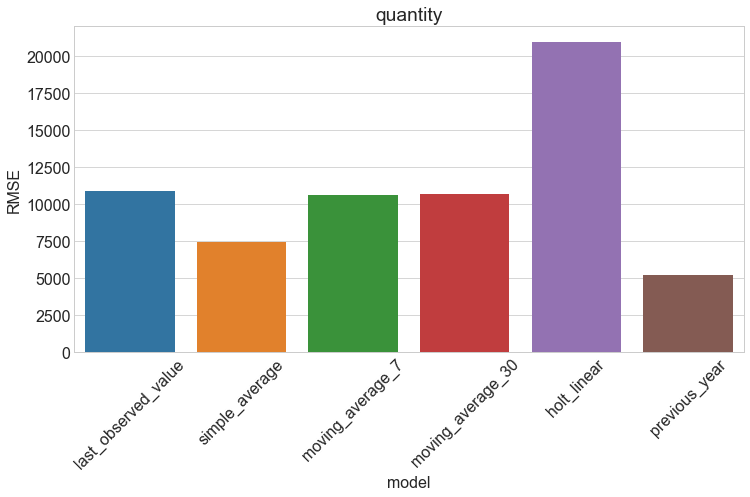

In [44]:
# Best Performer
for col in train.columns:
    x = metrics_df[metrics_df.target_var == col]['model']
    y = metrics_df[metrics_df.target_var == col]['RMSE']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()

## Takeaways
- Previous Cycle(Year) was the best perfomer, with the lowest RMSE indicating as such
- Visually it is a clear winner
- Apply the Model to the unseen data to see how it compares

In [45]:
# Run on Test Data
yhat_df = validate + train.diff(365).mean()
yhat_df.index = test.index

rmse_sales = round(sqrt(mean_squared_error(test['sales_total'], yhat_df['sales_total'])), 0)
rmse_quantity = round(sqrt(mean_squared_error(test['quantity'], yhat_df['quantity'])), 0)

rmse - dollars_sold:  27115.0
rmse - items_sold:  5041.0


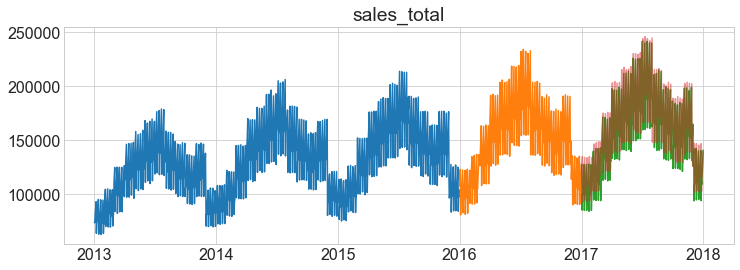

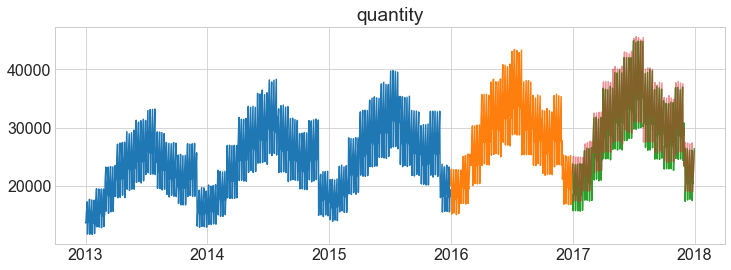

In [50]:
# Visualize
print("rmse - dollars_sold: ", rmse_sales)
print("rmse - items_sold: ", rmse_quantity)

for col in train.columns:
    final_plot(col)

# B - B - Bonus

   - Predict 2018 total monthly sales for a single store and/or item by creating a model.
   - Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper). The upper and lower bounds of the predictions are auto generated when using the facebook prophet model, or you could calculate your own using, for example, bollinger bands.
   - Plot the 2018 monthly sales predictions.


In [51]:
# Reset my data
df = wrangle.store_item_sales()
df = prepare.prep_store_data(df)
df.head(3)

Reading merged data from csv file...


,quantity,sale_id,store_id,item_brand,item_name,item_price,item_upc12,item_upc14,store_address,store_city,store_state,store_zipcode,sales_total,month,day_of_week
sale_date,,,,,,,,,,,,,,,
2013-01-01,13.0,1,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,10.92,January,Tuesday
2013-01-01,26.0,211817,7,Mueller,Mueller Sport Care Basic Support Level Medium Elastic Knee Support,8.40,74676640211,74676640211,12018 Perrin Beitel Rd,San Antonio,TX,78217,218.40,January,Tuesday
2013-01-01,27.0,832657,7,Mama Marys,Pizza Sauce,4.65,35457770664,35457770664,12018 Perrin Beitel Rd,San Antonio,TX,78217,125.55,January,Tuesday
